In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets,transforms
from torch.autograd import Variable
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
is_cuda=False
if torch.cuda.is_available():
    is_cuda = True

In [3]:
transformation = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.1307,), (0.3081,))])

train_dataset = datasets.MNIST('images/',train=True,transform=transformation,download=True)
test_dataset = datasets.MNIST('images/',train=False,transform=transformation,download=True)

train_loader = torch.utils.data.DataLoader(train_dataset,batch_size=32,shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset,batch_size=32,shuffle=True)

In [4]:
sample_data = next(iter(train_loader))

In [5]:
def plot_img(image):
    image = image.numpy()[0]
    mean = 0.1307
    std = 0.3081
    image = ((mean * image) + std)
    plt.imshow(image,cmap='gray')

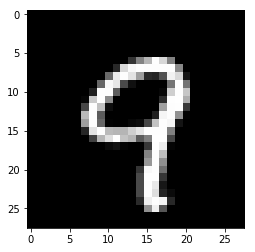

In [6]:
plot_img(sample_data[0][2])

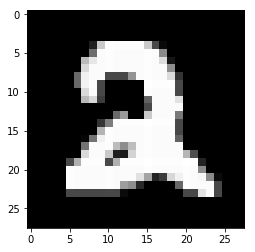

In [7]:
plot_img(sample_data[0][1])

In [8]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        #x = F.dropout(x,p=0.1, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x,dim=1)

In [9]:
model = Net()
if is_cuda:
    model.cuda()

In [10]:
optimizer = optim.SGD(model.parameters(),lr=0.01)

In [11]:
data , target = next(iter(train_loader))

In [12]:
if is_cuda:
    data=data.cuda()

In [13]:
output = model(Variable(data))

In [14]:
output.size()

torch.Size([32, 10])

In [15]:
target.size()

torch.Size([32])

In [16]:
def fit(epoch,model,data_loader,phase='training',volatile=False):
    if phase == 'training':
        model.train()
    if phase == 'validation':
        model.eval()
        volatile=True
    running_loss = 0.0
    running_correct = 0
    for batch_idx , (data,target) in enumerate(data_loader):
        if is_cuda:
            data,target = data.cuda(),target.cuda()
        data , target = Variable(data,volatile),Variable(target)
        if phase == 'training':
            optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output,target)
        
        running_loss += F.nll_loss(output,target, reduction='sum').data
        preds = output.data.max(dim=1,keepdim=True)[1]
        running_correct += preds.eq(target.data.view_as(preds)).cpu().sum()
        if phase == 'training':
            loss.backward()
            optimizer.step()
    
    loss = running_loss.item()/len(data_loader.dataset)
    accuracy = 100.0 * running_correct.item()/len(data_loader.dataset)
    
    print(f'{phase} loss is {loss:{5}.{2}} and {phase} accuracy is {running_correct}/{len(data_loader.dataset)} {accuracy:{10}.{4}}')
    return loss,accuracy

In [17]:
train_losses , train_accuracy = [],[]
val_losses , val_accuracy = [],[]
for epoch in range(1,10):
    epoch_loss, epoch_accuracy = fit(epoch,model,train_loader,phase='training')
    val_epoch_loss , val_epoch_accuracy = fit(epoch,model,test_loader,phase='validation')
    train_losses.append(epoch_loss)
    train_accuracy.append(epoch_accuracy)
    val_losses.append(val_epoch_loss)
    val_accuracy.append(val_epoch_accuracy)

training loss is  0.58 and training accuracy is 49470/60000      82.45
validation loss is  0.16 and validation accuracy is 9534/10000      95.34
training loss is   0.2 and training accuracy is 56502/60000      94.17
validation loss is   0.1 and validation accuracy is 9682/10000      96.82
training loss is  0.15 and training accuracy is 57335/60000      95.56
validation loss is 0.078 and validation accuracy is 9755/10000      97.55
training loss is  0.13 and training accuracy is 57742/60000      96.24
validation loss is 0.062 and validation accuracy is 9797/10000      97.97
training loss is  0.11 and training accuracy is 57989/60000      96.65
validation loss is 0.064 and validation accuracy is 9804/10000      98.04
training loss is   0.1 and training accuracy is 58232/60000      97.05
validation loss is 0.052 and validation accuracy is 9824/10000      98.24
training loss is 0.093 and training accuracy is 58366/60000      97.28
validation loss is 0.047 and validation accuracy is 9848/10

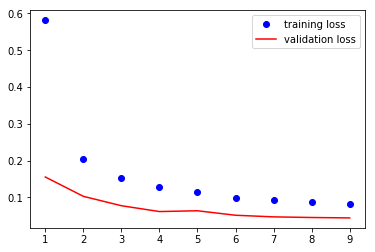

In [18]:
plt.plot(range(1,len(train_losses)+1),train_losses,'bo',label = 'training loss')
plt.plot(range(1,len(val_losses)+1),val_losses,'r',label = 'validation loss')
plt.legend()

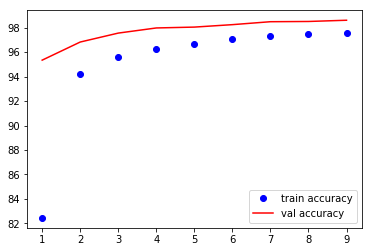

In [19]:
plt.plot(range(1,len(train_accuracy)+1),train_accuracy,'bo',label = 'train accuracy')
plt.plot(range(1,len(val_accuracy)+1),val_accuracy,'r',label = 'val accuracy')
plt.legend()

## 1d 컨볼루션 이해

In [20]:
conv = nn.Conv1d(1,1,3,bias=False)

In [21]:
conv.weight

Parameter containing:
tensor([[[ 0.5769, -0.2399, -0.4371]]], requires_grad=True)

In [22]:
sample = torch.randn(1,1,7)

In [23]:
sample

tensor([[[ 1.4066, -1.4255,  0.8351,  0.6400,  0.7762, -0.0332, -0.4396]]])

In [24]:
conv(Variable(sample))

tensor([[[ 0.7885, -1.3025, -0.0110,  0.1976,  0.6479]]],
       grad_fn=<SqueezeBackward1>)

### Conv1d에서 패딩이 동작하는 방식 이해

In [25]:
conv = nn.Conv1d(1,1,3,padding=2,bias=False)
conv.weight

Parameter containing:
tensor([[[ 0.5248,  0.2510, -0.3515]]], requires_grad=True)

In [26]:
sample = torch.randn(1,1,7)
sample

tensor([[[-1.0375, -0.2166, -0.0509, -1.1291,  1.5635, -0.0708, -0.3998]]])

In [27]:
conv(Variable(sample))

tensor([[[ 0.3647, -0.1843, -0.5810,  0.2705, -0.8598, -0.1752,  0.9433,
          -0.1376, -0.2098]]], grad_fn=<SqueezeBackward1>)